In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
# Download necessary NLTK data
import nltk
from jupyter_core.version import pattern

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load and display the data


In [4]:
# Define the path to the manually downloaded dataset
data_path = "data/data.csv"  # Update the file name if it's different

# Check if the file exists before attempting to load
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset file not found at {data_path}. Ensure the file is in the correct location.")

# Load the dataset
df= pd.read_csv(data_path)
print("Dataset loaded successfully!")

# Display the first few rows of the DataFrame
df.head()


Dataset loaded successfully!


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


# Drop the neutral class


In [5]:
# Assuming the sentiment labels are stored in a column named 'sentiment'
sentiment_column = 'Sentiment'  # Replace with the actual column name in your dataset

# Check the unique values in the sentiment column to confirm the presence of 'neutral'
print("Unique sentiment labels before filtering:", df[sentiment_column].unique())

# Drop rows where sentiment is 'neutral'
df_filtered = df[df[sentiment_column] != 'neutral']

# Display the first few rows of the filtered DataFrame
print("Dataset after dropping the 'neutral' class:")
df_filtered.head()

# Optionally, save the filtered dataset to a new CSV file
filtered_data_path = "data/filtered_data.csv"  # Update as needed
df_filtered.to_csv(filtered_data_path, index=False)
print(f"Filtered dataset saved to {filtered_data_path}")


Unique sentiment labels before filtering: ['positive' 'negative' 'neutral']
Dataset after dropping the 'neutral' class:
Filtered dataset saved to data/filtered_data.csv


# Use the new dataset that is generated


In [6]:
data_path = "data/filtered_data.csv"  # Update the file name if it's different
# Load the dataset
df= pd.read_csv(data_path)
print("Dataset loaded successfully!")

# Display the first few rows of the DataFrame
df.head()



Dataset loaded successfully!


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,$SPY wouldn't be surprised to see a green close,positive
4,Shell's $70 Billion BG Deal Meets Shareholder ...,negative


# Perfrom EDA on the dataset to understand the distribution of classes


Class distribution:
Sentiment
positive    1852
negative     860
Name: count, dtype: int64

Text length stats:
count    2712.000000
mean      109.992257
std        55.073596
min        10.000000
25%        67.000000
50%        98.000000
75%       140.000000
max       298.000000
Name: text_length, dtype: float64


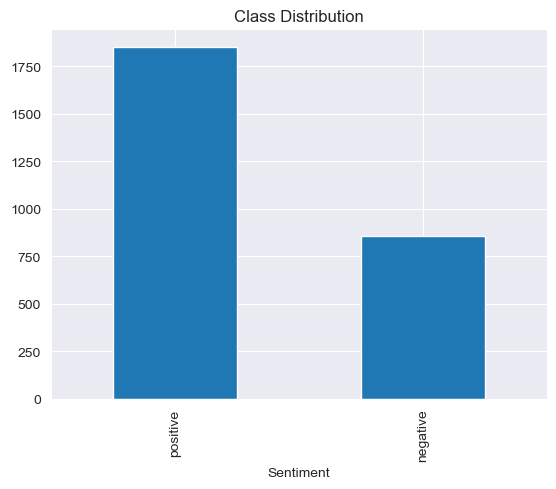

In [7]:
# Perform Exploratory Data Analysis (EDA)
def perform_eda(data):
    # Check class distribution
    print("Class distribution:")
    print(df['Sentiment'].value_counts())

    # Text length analysis
    df['text_length'] = df['Sentence'].apply(len)
    print("\nText length stats:")
    print(df['text_length'].describe())

    # Visualize class distribution
    df['Sentiment'].value_counts().plot(kind='bar', title="Class Distribution")
    plt.show()
perform_eda(df)

# Preprocess the text data
In this section we will preprocess the text data by performing the following steps:
1. Remove extra whitespaces
2. Remove HTML tags
3. Remove URLs
4. Decode HTML entities
5. Replace stock tickers (e.g., $AAPL) with a special token 'STOCK'
6. Handle currencies (e.g., $10k, €20)
7. Remove space between digits and decimal points
8. Remove space before or after a comma in large numbers
9. Ensure that numbers with units (e.g., EUR 1.6 m) have no spaces
10. Replace percentages
11. Replace months, dates, years, and hours
12. Remove special characters
13. Tokenize the text
14. Remove punctuation
15. Remove stopwords
16. Apply stemming
17. Join tokens back into text

In [8]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import html
import string
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources if not already done
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_and_stem(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', 'url', text)

    # Decode HTML entities
    text = html.unescape(text)

    # Replace stock tickers with 'STOCK'
    text = re.sub(r'\$[A-Za-z]+', 'STOCK', text)

    # Handle cases with currencies like USD, EUR, GBP, etc.
    text = re.sub(r'(\b(?:USD|EUR|GBP|INR|JPY|CAD|AUD|CHF|CNY|ZAR|SEK|NOK|¥|€|₹|£))\s?(\d+(\,?\d{3})*(\.\d{1,2})?)', r'\1\2', text)

    # Remove space between digits and decimal points
    text = re.sub(r'(\d)\s?\.(\d)', r'\1.\2', text)  # For cases like 1 .6 -> 1.6

    # Remove space before or after a comma in large numbers like EUR1 ,000
    text = re.sub(r'(\d)\s?,(\d)', r'\1,\2', text)  # For cases like EUR1 ,000 -> EUR1,000

    # Ensure that numbers with units (e.g., EUR 1.6 m) have no spaces
    text = re.sub(r'(\d)\s?(billion|million|bn|mn|mln)', r'\1\2', text,flags=re.IGNORECASE)

    pattern = r"(?:(?:[\$\€\¥\£])\s?\d+(?:,\d{3})*(?:\.\d+)?(?:\s?(?:[kK]|[mM]illion|[bB]illion|[tT]housand|[mM][nNlL]?|[bB][nN]?)?)?)"
    text = re.sub(pattern, r"value ", text)  # Add a space after "money_value"

    pattern2 = r"(?:USD|EUR|GBP|JPY|AUD|CAD)\s?\d+(?:,\d{3})*(?:\.\d+)?(?:\s?(?:[kK]|[mM]illion|[bB]illion|[tT]housand|[mM][nNlL]?|[bB][nN]?)?)"
    text = re.sub(pattern2, r"value ", text)  # Add a space after "money_value"

    # Replace percentages
    text = re.sub(r'\d+(\.\d+)?\s?%|(\d+(\.\d+)?\s?percent)', 'percentage', text, flags=re.IGNORECASE)
    # Replace months, dates, years, and hours
    text = re.sub(r'\b(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\b', 'month', text)
    text = re.sub(r'\b\d{4}\b', 'year', text)
    text = re.sub(r'\b\d{1,2}(st|nd|rd|th)\b', 'date', text)
    text = re.sub(r'\b\d{1,2}[:]\d{2}\b', 'hour', text)

    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Tokenize and clean up text
    tokens = word_tokenize(text.lower())

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into text
    return ' '.join(stemmed_tokens)

# Apply the cleaning function to the 'Sentence' column and create a new column 'cleaned_text'
df['cleaned_text'] = df['Sentence'].apply(clean_and_stem)
df.head(100)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Sentence,Sentiment,text_length,cleaned_text
0,The GeoSolutions technology will leverage Bene...,positive,218,the geosolut technolog will leverag benefon s ...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55,stock on low down valu to valu k a real possibl
2,"For the last quarter of 2010 , Componenta 's n...",positive,193,for the last quarter of year componenta s net ...
3,$SPY wouldn't be surprised to see a green close,positive,47,stock wouldnt be surpris to see a green close
4,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,56,shell valu bg deal meet sharehold skeptic
...,...,...,...,...
95,The pretax profit of the group 's life insuran...,positive,91,the pretax profit of the group s life insur bu...
96,RT @alphatrends VMarkets Are Still Acting Weak...,negative,92,rt alphatrend vmarket are still act weak url s...
97,One of the installed elevators will be a doubl...,positive,128,one of the instal elev will be a doubledeck el...
98,Just went long $ILMN,positive,20,just went long stock


# Now we will split the data into training and testing sets
we do this before resampling and feature extraction to avoid data leakage


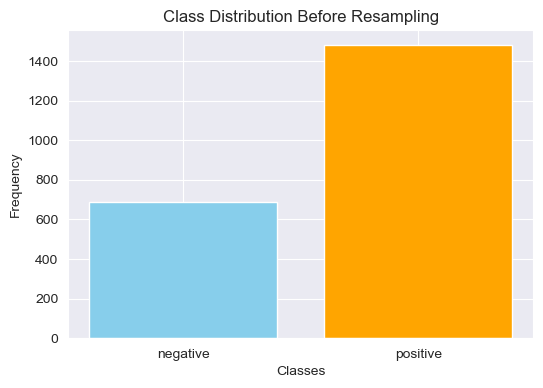

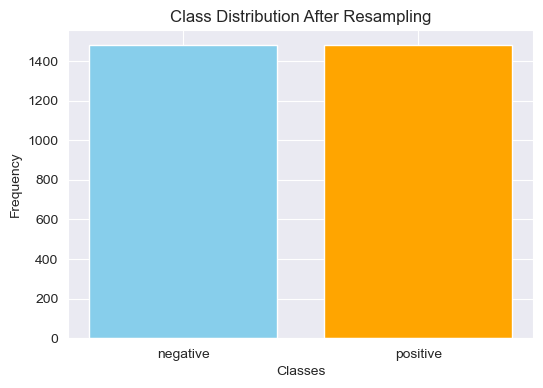

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Assuming your dataset has 'cleaned_text' and 'Sentiment' columns
X = df['cleaned_text']
y = df['Sentiment']

# Encode the labels (Positive, Negative -> 1, 0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Convert training text to numerical features (e.g., TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Visualize class distribution before resampling
def plot_class_distribution(y_data, title, labels):
    counts = Counter(y_data)
    plt.figure(figsize=(6, 4))
    plt.bar(counts.keys(), counts.values(), color=['skyblue', 'orange'])
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show()

# Plot before resampling
plot_class_distribution(y_train, "Class Distribution Before Resampling", labels=label_encoder.classes_)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Plot after resampling
plot_class_distribution(y_train_resampled, "Class Distribution After Resampling", labels=label_encoder.classes_)

# Transform the test set using the same TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Running the LSTM model


Using device: cuda


Epoch 5: 100%|██████████| 93/93 [00:00<00:00, 243.46it/s, accuracy=99.4, loss=0.000274]


Early stopping
Accuracy: 0.8360957642725598
F1 score : 0.8805369127516779
AUC Score: 0.8989453394345892


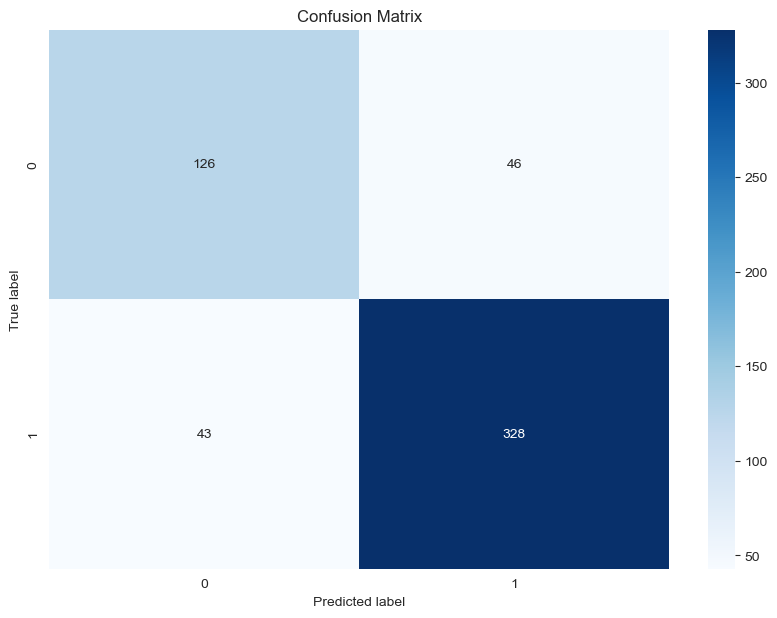

Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.73      0.74       172
    Positive       0.88      0.88      0.88       371

    accuracy                           0.84       543
   macro avg       0.81      0.81      0.81       543
weighted avg       0.84      0.84      0.84       543



In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset for TF-IDF features
class TfidfDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx])
        label = torch.LongTensor([self.labels[idx]])
        return feature, label

# Create dataset objects
train_dataset = TfidfDataset(X_train_resampled.toarray(), y_train_resampled)
test_dataset = TfidfDataset(X_test_tfidf.toarray(), y_test)

# DataLoader for batching the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define LSTM model with dropout for regularization
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Apply dropout to the last hidden state
        out = self.dropout(out[:, -1, :])

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train_resampled.shape[1]  # Number of TF-IDF features
hidden_size = 256
num_layers = 2
num_classes = 2  # Assuming binary sentiment classification
dropout_rate = 0.3

# Instantiate the model
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)

# Loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW with weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)  # Learning Rate Scheduling

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.01)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for features, labels in loop:
        features, labels = features.to(device), labels.squeeze().to(device)

        # Forward pass
        outputs = model(features.unsqueeze(1))  # Add sequence dimension for LSTM
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, labels in test_loader:  # Here we use test_loader as validation, adjust if you have a separate validation set
            features, labels = features.to(device), labels.squeeze().to(device)
            outputs = model(features.unsqueeze(1))
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(test_loader)

    # Learning Rate Scheduling
    scheduler.step(val_loss)

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluation (use your previous evaluation code here)
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.squeeze().to(device)
        outputs = model(features.unsqueeze(1))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1])  # Assuming class 1 is the positive class

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")
# F1 Score
f1 = f1_score(all_labels, all_preds)
print(f"F1 score : {f1}")
# AUC Score
auc = roc_auc_score(all_labels, all_probs)
print(f"AUC Score: {auc}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

# CNN Model for sentimet analysis



Using device: cuda


Epoch 4: 100%|██████████| 93/93 [00:00<00:00, 168.60it/s, accuracy=99.3, loss=0.0151]  


Early stopping


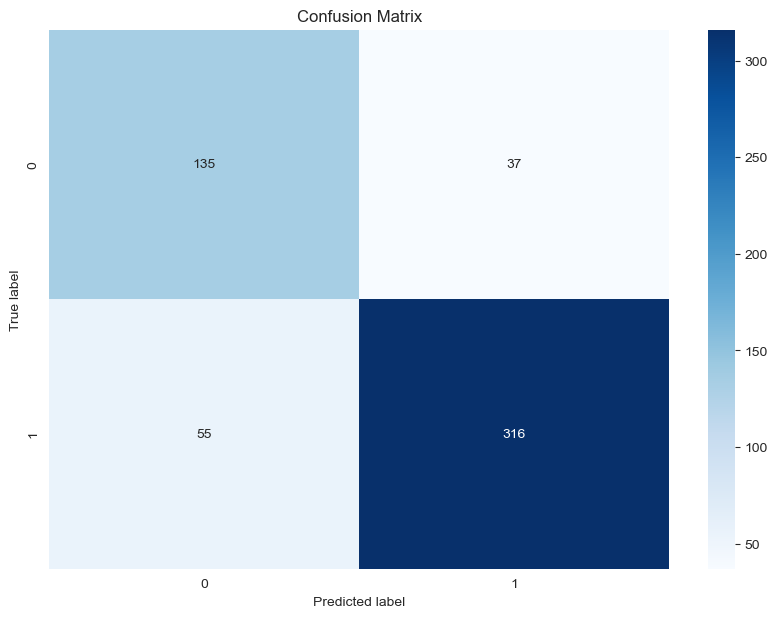

Accuracy: 0.8305709023941068
F1 score : 0.8729281767955801
Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.78      0.75       172
    Positive       0.90      0.85      0.87       371

    accuracy                           0.83       543
   macro avg       0.80      0.82      0.81       543
weighted avg       0.84      0.83      0.83       543

AUC Score: 0.8908120729643327


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix , f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import    ReduceLROnPlateau

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset for TF-IDF features
class TfidfDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx])
        label = torch.LongTensor([self.labels[idx]])
        return feature, label

# Create dataset objects
train_dataset = TfidfDataset(X_train_resampled.toarray(), y_train_resampled)
test_dataset = TfidfDataset(X_test_tfidf.toarray(), y_test)

# DataLoader for batching the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN model with dropout for regularization

class CNNClassifier(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.3):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=x.size(2))  # Global max pooling
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = X_train_resampled.shape[1]  # Number of TF-IDF features
num_classes = 2  # Assuming binary sentiment classification
dropout_rate = 0.3

# Instantiate the model
model = CNNClassifier(input_size, num_classes, dropout_rate).to(device)

# Loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW with weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)  #

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.01)

# Training loop
epochs = 5

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for features, labels in loop:
        features, labels = features.to(device), labels.squeeze().to(device)

        # Forward pass
        outputs = model(features.unsqueeze(1).permute(0, 2, 1))  # Add channel dimension for CNN
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, labels in test_loader:  # Here we use test_loader as validation, adjust if you have a separate validation set
            features, labels = features.to(device), labels.squeeze().to(device)
            outputs = model(features.unsqueeze(1).permute(0, 2, 1))
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(test_loader)

    # Learning Rate Scheduling
    scheduler.step(val_loss)

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluation (use your previous evaluation code here)
model.eval()
all_preds_cnn = []
all_labels_cnn = []
all_probs_cnn = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.squeeze().to(device)
        outputs = model(features.unsqueeze(1).permute(0, 2, 1))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_cnn.extend(predicted.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())
        all_probs_cnn.extend(probs.cpu().numpy()[:, 1])  # Assuming class 1 is the positive class

# Metrics and visualization
#confusion matrix
cm = confusion_matrix(all_labels_cnn, all_preds_cnn)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#accuracy
accuracy = accuracy_score(all_labels_cnn, all_preds_cnn)
print(f"Accuracy: {accuracy}")
#F1 score
f1 = f1_score(all_labels_cnn, all_preds_cnn)
print(f"F1 score : {f1}")
#classifiaction report
print("Classification Report:")
print(classification_report(all_labels_cnn, all_preds_cnn, target_names=['Negative', 'Positive']))
#AUC score
auc = roc_auc_score(all_labels_cnn, all_probs_cnn)
print(f"AUC Score: {auc}")

# ROC curve for the CNN model and LSTM model

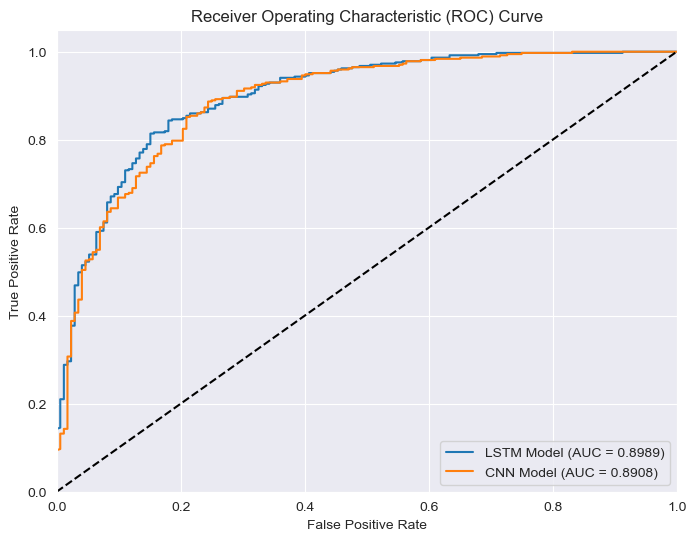

In [12]:
from sklearn.metrics import roc_curve, auc
# ROC curve for the CNN model
fpr_cnn, tpr_cnn, thresholds = roc_curve(all_labels_cnn, all_probs_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# ROC curve for the LSTM model
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for both moedls
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LSTM Model (AUC = {roc_auc:.4f})')
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN Model (AUC = {roc_auc_cnn:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


## As we did with the ML model now we will use stemming with stopwords removal

In [13]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import html
import string

# Download necessary NLTK resources if not already done
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_and_stem(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', 'url', text)

    # Decode HTML entities
    text = html.unescape(text)

    # Replace stock tickers with 'STOCK'
    text = re.sub(r'\$[A-Za-z]+', 'STOCK', text)

    # Handle cases with currencies like USD, EUR, GBP, etc.
    text = re.sub(r'(\b(?:USD|EUR|GBP|INR|JPY|CAD|AUD|CHF|CNY|ZAR|SEK|NOK|¥|€|₹|£))\s?(\d+(\,?\d{3})*(\.\d{1,2})?)', r'\1\2', text)

    # Remove space between digits and decimal points
    text = re.sub(r'(\d)\s?\.(\d)', r'\1.\2', text)  # For cases like 1 .6 -> 1.6

    # Remove space before or after a comma in large numbers like EUR1 ,000
    text = re.sub(r'(\d)\s?,(\d)', r'\1,\2', text)  # For cases like EUR1 ,000 -> EUR1,000

    # Ensure that numbers with units (e.g., EUR 1.6 m) have no spaces
    text = re.sub(r'(\d)\s?(billion|million|bn|mn|mln)', r'\1\2', text,flags=re.IGNORECASE)

    pattern = r"(?:(?:[\$\€\¥\£])\s?\d+(?:,\d{3})*(?:\.\d+)?(?:\s?(?:[kK]|[mM]illion|[bB]illion|[tT]housand|[mM][nNlL]?|[bB][nN]?)?)?)"
    text = re.sub(pattern, r"value ", text)  # Add a space after "money_value"

    pattern2 = r"(?:USD|EUR|GBP|JPY|AUD|CAD)\s?\d+(?:,\d{3})*(?:\.\d+)?(?:\s?(?:[kK]|[mM]illion|[bB]illion|[tT]housand|[mM][nNlL]?|[bB][nN]?)?)"
    text = re.sub(pattern2, r"value ", text)  # Add a space after "money_value"

    # Replace percentages
    text = re.sub(r'\d+(\.\d+)?\s?%|(\d+(\.\d+)?\s?percent)', 'percentage', text, flags=re.IGNORECASE)
    # Replace months, dates, years, and hours
    text = re.sub(r'\b(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\b', 'month', text)
    text = re.sub(r'\b\d{4}\b', 'year', text)
    text = re.sub(r'\b\d{1,2}(st|nd|rd|th)\b', 'date', text)
    text = re.sub(r'\b\d{1,2}[:]\d{2}\b', 'hour', text)

    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Tokenize and clean up text
    tokens = word_tokenize(text.lower())

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Use custom stopwords
    custom_stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in custom_stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into text
    return ' '.join(stemmed_tokens)

# Apply the cleaning function to the 'Sentence' column and create a new column 'cleaned_text'
df['cleaned_text'] = df['Sentence'].apply(clean_and_stem)
df.head(100)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Sentence,Sentiment,text_length,cleaned_text
0,The GeoSolutions technology will leverage Bene...,positive,218,geosolut technolog leverag benefon gp solut pr...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55,stock low valu valu k real possibl
2,"For the last quarter of 2010 , Componenta 's n...",positive,193,last quarter year componenta net sale doubl va...
3,$SPY wouldn't be surprised to see a green close,positive,47,stock wouldnt surpris see green close
4,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,56,shell valu bg deal meet sharehold skeptic
...,...,...,...,...
95,The pretax profit of the group 's life insuran...,positive,91,pretax profit group life insur busi increas va...
96,RT @alphatrends VMarkets Are Still Acting Weak...,negative,92,rt alphatrend vmarket still act weak url stock...
97,One of the installed elevators will be a doubl...,positive,128,one instal elev doubledeck elev enabl effici u...
98,Just went long $ILMN,positive,20,went long stock


# Split the data into training and testing sets and resample the training data to balance the classes

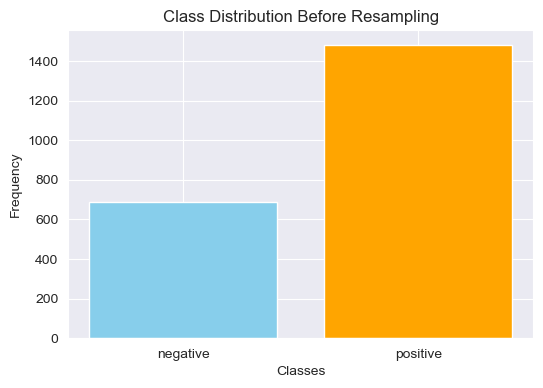

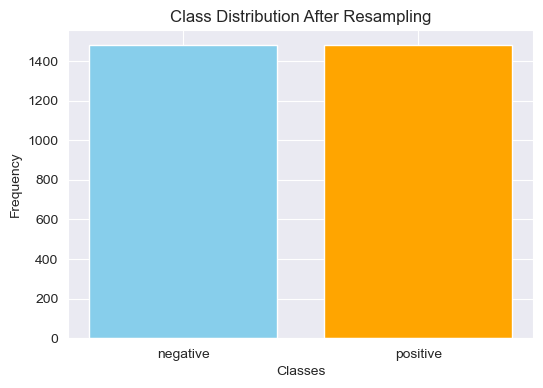

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Assuming your dataset has 'cleaned_text' and 'Sentiment' columns
X = df['cleaned_text']
y = df['Sentiment']

# Encode the labels (Positive, Negative -> 1, 0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Convert training text to numerical features (e.g., TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Visualize class distribution before resampling
def plot_class_distribution(y_data, title, labels):
    counts = Counter(y_data)
    plt.figure(figsize=(6, 4))
    plt.bar(counts.keys(), counts.values(), color=['skyblue', 'orange'])
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show()

# Plot before resampling
plot_class_distribution(y_train, "Class Distribution Before Resampling", labels=label_encoder.classes_)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Plot after resampling
plot_class_distribution(y_train_resampled, "Class Distribution After Resampling", labels=label_encoder.classes_)

# Transform the test set using the same TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# And now we will run the LSTM model with the new data that has been preprocessed and resampled

Using device: cuda


Epoch 4: 100%|██████████| 93/93 [00:00<00:00, 225.40it/s, accuracy=98.5, loss=0.00921]


Early stopping
Accuracy: 0.7900552486187845
F1 score : 0.8471849865951743
AUC Score: 0.8710117219331788


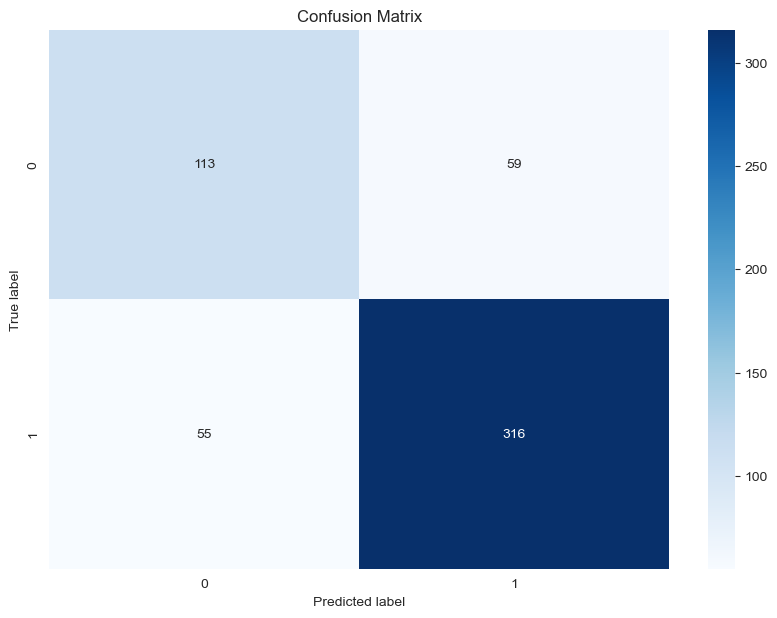

Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.66      0.66       172
    Positive       0.84      0.85      0.85       371

    accuracy                           0.79       543
   macro avg       0.76      0.75      0.76       543
weighted avg       0.79      0.79      0.79       543



In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset for TF-IDF features
class TfidfDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx])
        label = torch.LongTensor([self.labels[idx]])
        return feature, label

# Create dataset objects
train_dataset = TfidfDataset(X_train_resampled.toarray(), y_train_resampled)
test_dataset = TfidfDataset(X_test_tfidf.toarray(), y_test)

# DataLoader for batching the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define LSTM model with dropout for regularization
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Apply dropout to the last hidden state
        out = self.dropout(out[:, -1, :])

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train_resampled.shape[1]  # Number of TF-IDF features
hidden_size = 256
num_layers = 2
num_classes = 2  # Assuming binary sentiment classification
dropout_rate = 0.3

# Instantiate the model
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)

# Loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW with weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)  # Learning Rate Scheduling

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.01)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for features, labels in loop:
        features, labels = features.to(device), labels.squeeze().to(device)

        # Forward pass
        outputs = model(features.unsqueeze(1))  # Add sequence dimension for LSTM
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, labels in test_loader:  # Here we use test_loader as validation, adjust if you have a separate validation set
            features, labels = features.to(device), labels.squeeze().to(device)
            outputs = model(features.unsqueeze(1))
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(test_loader)

    # Learning Rate Scheduling
    scheduler.step(val_loss)

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluation (use your previous evaluation code here)
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.squeeze().to(device)
        outputs = model(features.unsqueeze(1))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1])  # Assuming class 1 is the positive class

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")
f1 = f1_score(all_labels, all_preds)
print(f"F1 score : {f1}")
# AUC Score
auc = roc_auc_score(all_labels, all_probs)
print(f"AUC Score: {auc}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

## Now we will run the CNN model with the new preprocessed and resampled data

Using device: cuda


Epoch 4: 100%|██████████| 93/93 [00:00<00:00, 157.19it/s, accuracy=99, loss=0.196]    


Early stopping


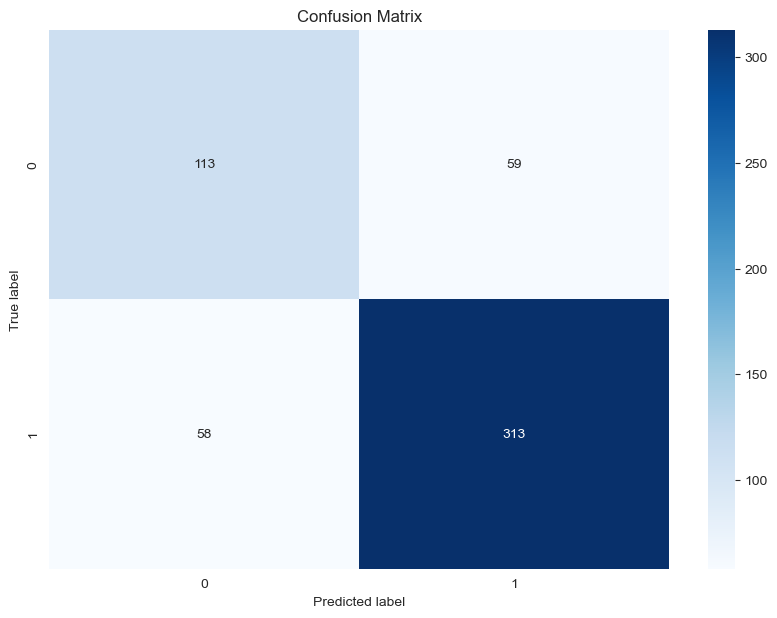

Accuracy: 0.7845303867403315
F1 score : 0.8425302826379543
Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.66      0.66       172
    Positive       0.84      0.84      0.84       371

    accuracy                           0.78       543
   macro avg       0.75      0.75      0.75       543
weighted avg       0.78      0.78      0.78       543

AUC Score: 0.8588823418792704


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import    ReduceLROnPlateau

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset for TF-IDF features
class TfidfDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx])
        label = torch.LongTensor([self.labels[idx]])
        return feature, label

# Create dataset objects
train_dataset = TfidfDataset(X_train_resampled.toarray(), y_train_resampled)
test_dataset = TfidfDataset(X_test_tfidf.toarray(), y_test)

# DataLoader for batching the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN model with dropout for regularization

class CNNClassifier(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.3):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=x.size(2))  # Global max pooling
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = X_train_resampled.shape[1]  # Number of TF-IDF features
num_classes = 2  # Assuming binary sentiment classification
dropout_rate = 0.3

# Instantiate the model
model = CNNClassifier(input_size, num_classes, dropout_rate).to(device)

# Loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW with weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)  #

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.01)

# Training loop
epochs = 5

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for features, labels in loop:
        features, labels = features.to(device), labels.squeeze().to(device)

        # Forward pass
        outputs = model(features.unsqueeze(1).permute(0, 2, 1))  # Add channel dimension for CNN
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, labels in test_loader:  # Here we use test_loader as validation, adjust if you have a separate validation set
            features, labels = features.to(device), labels.squeeze().to(device)
            outputs = model(features.unsqueeze(1).permute(0, 2, 1))
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(test_loader)

    # Learning Rate Scheduling
    scheduler.step(val_loss)

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluation (use your previous evaluation code here)
model.eval()
all_preds_cnn = []
all_labels_cnn = []
all_probs_cnn = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.squeeze().to(device)
        outputs = model(features.unsqueeze(1).permute(0, 2, 1))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_cnn.extend(predicted.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())
        all_probs_cnn.extend(probs.cpu().numpy()[:, 1])  # Assuming class 1 is the positive class

# Metrics and visualization
#confusion matrix
cm = confusion_matrix(all_labels_cnn, all_preds_cnn)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#accuracy
accuracy = accuracy_score(all_labels_cnn, all_preds_cnn)
print(f"Accuracy: {accuracy}")
#f1 score
f1 = f1_score(all_labels_cnn, all_preds_cnn)
print(f"F1 score : {f1}")
#classifiaction report
print("Classification Report:")
print(classification_report(all_labels_cnn, all_preds_cnn, target_names=['Negative', 'Positive']))
#AUC score
auc = roc_auc_score(all_labels_cnn, all_probs_cnn)
print(f"AUC Score: {auc}")

## ROC curve for the CNN model and LSTM model with the new preprocessed and resampled data

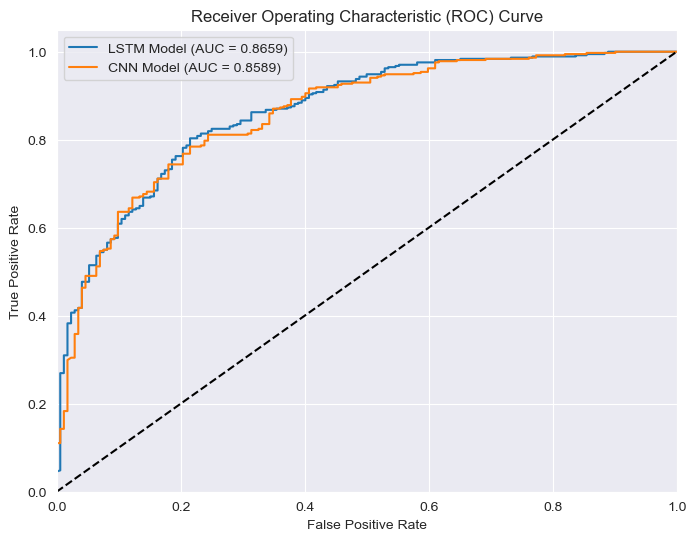

In [17]:
from sklearn.metrics import roc_curve, auc
# ROC curve for the CNN model
fpr_cnn, tpr_cnn, thresholds = roc_curve(all_labels_cnn, all_probs_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# ROC curve for the LSTM model
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for both moedls
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LSTM Model (AUC = {roc_auc:.4f})')
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN Model (AUC = {roc_auc_cnn:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()